# Bidirectional RNNs
This notebook will be a fairly straightforward extension on VanillaRNNs. Make sure you go through that notebook before checking this one, but once you do, this one will be an extremely straightforward modification (just copy & paste your code here as a base before making the corresponding changes).

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(0)

In [3]:
def plot_model(model, T, csv_fn):
  dataset_test = pd.read_csv(csv_fn)
  real_stock_price = dataset_test.iloc[:, 1:2].values

  # Getting the predicted stock price of 2017
  dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
  inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)
  X_test = []

  for i in range(T, inputs.shape[0]):
      X_test.append(torch.tensor(inputs[i-T:i, 0]))

  X_test = torch.stack(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  if model is not None:
    predicted_stock_price = model(X_test).detach().numpy()
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

  # Visualising the results
  plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
  if model is not None:
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
  plt.title('Google Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Google Stock Price')
  plt.legend()
  plt.show()

if not os.path.exists("Google_Stock_Price_Train.csv"):
    url = "https://raw.githubusercontent.com/kevincwu0/rnn-google-stock-prediction/master/Google_Stock_Price_Train.csv"
    urllib.request.urlretrieve(url, "Google_Stock_Price_Train.csv")

if not os.path.exists("Google_Stock_Price_Test.csv"):
    url = "https://raw.githubusercontent.com/kevincwu0/rnn-google-stock-prediction/master/Google_Stock_Price_Test.csv"
    urllib.request.urlretrieve(url, "Google_Stock_Price_Test.csv")

dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values 

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

T = 60
D = 1
H = 8
O = 1

num_pts, _ = training_set_scaled.shape
X_train = []
y_train = []

for i in range(T, num_pts):
  X_train.append(torch.tensor(training_set_scaled[i-T:i]))
  y_train.append(torch.tensor(training_set_scaled[i]))

X_train = np.array(X_train)
y_train = np.array(y_train)

/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_4815/390531928.py:58: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X_train = np.array(X_train)
/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_4815/390531928.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)
/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel

Let's visualize the data to get a sense of what it looks like:

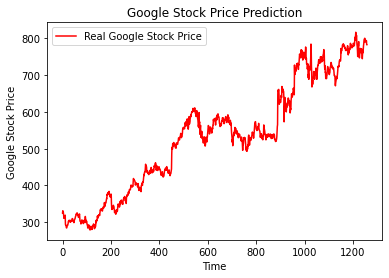

In [4]:
plot_model(None, 60, "Google_Stock_Price_Train.csv")

See the previous notebook for VanillaRNN math and concepts. For bidirectional RNNs, the concept is *exactly* the same, except that we have a forward *and* backward RNN that runs over the data to provide *two* hidden states, which are then concatenated together and multiplied by an output matrix to give the final prediction. In math:

\begin{split}\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}\end{split}

And as a diagram:

[](https://www.researchgate.net/profile/Weijiang-Feng/publication/318332317/figure/fig2/AS:614309566619650@1523474222076/Structure-of-a-bidirectional-RNN.png)

Let's go ahead and implement it:

In [5]:
class BidirectionalRNN(nn.Module):
    def __init__(self, D, H, O):
        super(BidirectionalRNN, self).__init__()

        self.D = D
        self.H = H
        self.O = O

        self.forward_Wxh = nn.Parameter(torch.ones((self.D, self.H)).type(torch.DoubleTensor))
        self.forward_Whh = nn.Parameter(torch.ones((self.H, self.H)).type(torch.DoubleTensor))

        self.backward_Wxh = nn.Parameter(torch.ones((self.D, self.H)).type(torch.DoubleTensor))
        self.backward_Whh = nn.Parameter(torch.ones((self.H, self.H)).type(torch.DoubleTensor))

        self.Who = nn.Parameter(torch.ones((2 * self.H, self.O)).type(torch.DoubleTensor))

    def forward(self, x):
        forward_h  = torch.zeros(self.H).type(torch.DoubleTensor)
        backward_h = torch.zeros(self.H).type(torch.DoubleTensor)

        N, T, D = x.shape
        for t in range(T):
            forward_x_i = x[:, t, :]
            forward_h = torch.tanh(torch.matmul(forward_x_i, self.forward_Wxh) \
                + torch.matmul(forward_h, self.forward_Whh))

            backward_x_i = x[:, -t, :]
            backward_h = torch.tanh(torch.matmul(backward_x_i, self.backward_Wxh) \
                + torch.matmul(backward_h, self.backward_Whh))

        h = torch.hstack([forward_h, backward_h])

        y_hat = torch.matmul(h, self.Who)
        return y_hat

In [8]:
# Use the below to test your VanillaRNN
T = 60
D = 1
H = 8
O = 1

model = BidirectionalRNN(D, H, O)
prediction = model(torch.stack([X_train[100]])).data[0,0].numpy()
assert(np.isclose(prediction, 16, atol=1e-05))

Great! Now, let's train it using the `X_train` and `y_train`. You'll want to do random sampling of `X_train` and `y_train` to create mini-batches for training. https://stackoverflow.com/questions/19485641/python-random-sample-of-two-arrays-but-matching-indices will be useful for that.

For a reference of how to write a training loop, take a look at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [9]:
"""
TODO: Implement the training loop for your model. Use MSELoss
for the loss. Visualize the results in the cell below. You should see
near perfect alignment for the first visualization and somewhat decent
prediction for the latter
"""

model = BidirectionalRNN(D, H, O)

loss_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
batch_size = 128
epochs = 2000

losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    idx = np.random.choice(np.arange(X_train.shape[0]), batch_size, replace=False)
    X_sample = torch.stack(list(X_train[idx]))
    y_sample = torch.stack(list(y_train[idx]))

    y_hat = model(X_sample)
    loss = loss_criterion(y_hat, y_sample)
    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epochs: {epoch}/{epochs} -- Loss: {loss}")
    losses.append(loss.detach().numpy())

Epochs: 0/2000 -- Loss: 240.60736607726903
Epochs: 100/2000 -- Loss: 192.98203525980608
Epochs: 200/2000 -- Loss: 154.83220387449808
Epochs: 300/2000 -- Loss: 119.94404301050461
Epochs: 400/2000 -- Loss: 0.002602121965529487
Epochs: 500/2000 -- Loss: 0.0023247212825766423
Epochs: 600/2000 -- Loss: 0.0022063361291028336
Epochs: 700/2000 -- Loss: 0.002157293894746986
Epochs: 800/2000 -- Loss: 0.0020458069361307288
Epochs: 900/2000 -- Loss: 0.0020801113839607607
Epochs: 1000/2000 -- Loss: 0.0020681653095772218
Epochs: 1100/2000 -- Loss: 0.0021750496018882264
Epochs: 1200/2000 -- Loss: 0.0016657737410281886
Epochs: 1300/2000 -- Loss: 0.0015834865854337317
Epochs: 1400/2000 -- Loss: 0.0017699230519310904
Epochs: 1500/2000 -- Loss: 0.0019271192314352682
Epochs: 1600/2000 -- Loss: 0.0013366336768420512
Epochs: 1700/2000 -- Loss: 0.0015007502286861496
Epochs: 1800/2000 -- Loss: 0.001379545509258347
Epochs: 1900/2000 -- Loss: 0.0014083281486504703


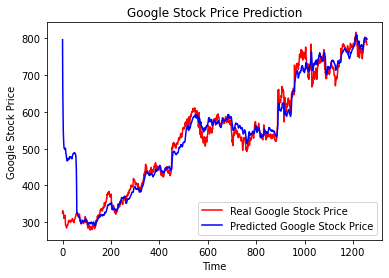

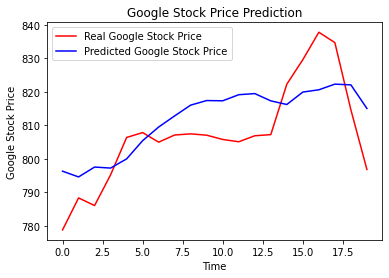

In [10]:
plot_model(model, T, "Google_Stock_Price_Train.csv") # should be nearly perfectly fit
plot_model(model, T, "Google_Stock_Price_Test.csv")